In [7]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter

In [9]:
# Upload the dataset Dir
files = os.listdir("C:/Users/92334/Desktop/Knowledge graph analysis with node2vec/Village_Dir") # here we change '\' into this '/
files

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/92334/Desktop/Knowledge graph analysis with node2vec/Village_Dir'

In [ ]:
# let's see how many samples and columns we have in each file in our directory
data_parts = {}
for file_name in files:
    file_id = file_name.split(".")[0]
    data_parts[file_id] = pd.read_csv("C:/Users/92334/Desktop/Knowledge graph analysis with node2vec/Village_Dir/" + file_name) # we had an issue and then we provided with one more "/" then issue of uploading the data just solved
    print(file_id)
    print(data_parts[file_id].shape)

In [ ]:
# 3. Build knowledge graph from CareerVillage data

def add_nodes(G, df, col, type_name):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes])
    print("Nodes (%s,%s) were added" % (col, type_name))
    
def add_links(G, df, col1, col2, type_name):
    """Add links to G from the 'df' DataFrame. The new edges are annotated with 'type_name' label."""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links])
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [5]:
G = nx.DiGraph()

In [6]:
#Nodes - The vertices of the knowledge graph consists of the following entities: answers, questions, 
#comments, students, professionals, industries, schools, tags, user groups, group types
add_nodes(G, data_parts["answers"], "answers_id", "answer")
add_nodes(G, data_parts["comments"], "comments_id", "comment")
add_nodes(G, data_parts["groups"], "groups_id", "group")
add_nodes(G, data_parts["groups"], "groups_group_type", "group_type")
add_nodes(G, data_parts["professionals"], "professionals_id", "professional")
add_nodes(G, data_parts["professionals"], "professionals_industry", "industry")
add_nodes(G, data_parts["questions"], "questions_id", "question")
add_nodes(G, data_parts["school_memberships"], "school_memberships_school_id", "school")
add_nodes(G, data_parts["students"], "students_id", "student")
add_nodes(G, data_parts["tags"], "tags_tag_id", "tag")

Nodes (answers_id,answer) were added
Nodes (comments_id,comment) were added
Nodes (groups_id,group) were added
Nodes (groups_group_type,group_type) were added
Nodes (professionals_id,professional) were added
Nodes (professionals_industry,industry) were added
Nodes (questions_id,question) were added
Nodes (school_memberships_school_id,school) were added
Nodes (students_id,student) were added
Nodes (tags_tag_id,tag) were added


In [7]:
#Edges
add_links(G, data_parts["answers"], "answers_id", "answers_question_id", "question")
add_links(G, data_parts["answers"], "answers_id", "answers_author_id", "author")
add_links(G, data_parts["comments"], "comments_id", "comments_parent_content_id", "parent_content")
add_links(G, data_parts["comments"], "comments_id", "comments_author_id", "author")
add_links(G, data_parts["group_memberships"], "group_memberships_user_id", "group_memberships_group_id", "member")
add_links(G, data_parts["groups"], "groups_id", "groups_group_type", "type")
add_links(G, data_parts["professionals"], "professionals_id", "professionals_industry", "type")
add_links(G, data_parts["questions"], "questions_id", "questions_author_id", "author")
add_links(G, data_parts["school_memberships"], "school_memberships_user_id", "school_memberships_school_id", "member")
add_links(G, data_parts["tag_questions"], "tag_questions_question_id", "tag_questions_tag_id", "tag")
add_links(G, data_parts["tag_users"], "tag_users_user_id", "tag_users_tag_id", "follow")

Edges (answers_id->answers_question_id,question) were added
Edges (answers_id->answers_author_id,author) were added
Edges (comments_id->comments_parent_content_id,parent_content) were added
Edges (comments_id->comments_author_id,author) were added
Edges (group_memberships_user_id->group_memberships_group_id,member) were added
Edges (groups_id->groups_group_type,type) were added
Edges (professionals_id->professionals_industry,type) were added
Edges (questions_id->questions_author_id,author) were added
Edges (school_memberships_user_id->school_memberships_school_id,member) were added
Edges (tag_questions_question_id->tag_questions_tag_id,tag) were added
Edges (tag_users_user_id->tag_users_tag_id,follow) were added


In [8]:
# Location Information
students = data_parts["students"]
profs = data_parts["professionals"]
students = students[~students["students_location"].isnull()]
profs = profs[~profs["professionals_location"].isnull()]

In [9]:
locs1 = list(students["students_location"])
locs2 = list(profs["professionals_location"])
locs = [loc.lower() for loc in locs1+locs2]
locs_unique = list(set(locs))

In [10]:
# Most common locations:
cnt = Counter(locs)
cnt.most_common()[:10]

[('new york, new york', 2650),
 ('bengaluru, karnataka, india', 1284),
 ('los angeles, california', 1280),
 ('boston, massachusetts', 1271),
 ('houston, texas', 1032),
 ('san francisco, california', 975),
 ('chicago, illinois', 920),
 ('california, california', 894),
 ('greater new york city area', 745),
 ('atlanta, georgia', 738)]

In [11]:
# Preprocess location information:
new_edges = []
new_nodes = []
for loc in locs_unique:
    loc_hierarchy = loc.split(", ")
    loc_nodes = [] # due to city name duplicates in the world
    k = len(loc_hierarchy)
    for i in range(k):
        loc_nodes.append('_'.join(loc_hierarchy[i:]))
    new_nodes += loc_nodes
    loc_links = [(loc_nodes[i],loc_nodes[i+1], dict(type="location"))  for i in range(k-1)]
    new_edges += loc_links
new_nodes = list(set(new_nodes))
new_nodes = [(n, dict(type="location")) for n in new_nodes]

In [12]:
#Add location nodes to the graph
#the 3 level of nodes are added
#connections between cities -> regions, regions -> contires are added

G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)
print(len(new_edges), len(new_nodes))

7253 7160


In [13]:
#Examples:
#Locations that are immediate in-neighbors of entity United Kingdom (e.g.: England, Scotland etc.).
list(G.in_edges("united kingdom"))[:5]

[('scotland_united kingdom', 'united kingdom'),
 ('england_united kingdom', 'united kingdom'),
 ('northern ireland_united kingdom', 'united kingdom'),
 ('reading_united kingdom', 'united kingdom'),
 ('sheffield_united kingdom', 'united kingdom')]

In [14]:
# Locations that are in-neighbors of entity England
list(G.in_edges("england_united kingdom"))[:5]

[('dudley_england_united kingdom', 'england_united kingdom'),
 ('taunton_england_united kingdom', 'england_united kingdom'),
 ('newcastle upon tyne_england_united kingdom', 'england_united kingdom'),
 ('tonbridge_england_united kingdom', 'england_united kingdom'),
 ('ascot_england_united kingdom', 'england_united kingdom')]

In [15]:
# Link users to the first level of locations:
students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))

C:\Users\92334\AppData\Local\Temp\ipykernel_7748\4294326106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
C:\Users\92334\AppData\Local\Temp\ipykernel_7748\4294326106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))


In [16]:
add_links(G, students, "students_id", "students_location", "location")
add_links(G, profs, "professionals_id", "professionals_location", "location")

Edges (students_id->students_location,location) were added
Edges (professionals_id->professionals_location,location) were added


In [17]:
# iv.) Clean and encode knowledge graph
def encode_graph(G):
    """Encode the nodes of the network into integers"""
    nodes = [(n,d.get("type",None)) for n, d in G.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[src], node2idx[trg], d.get("type",None)) for src, trg, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["src","trg","type"])
    return nodes_df, edges_df

In [18]:
# Remove isolated nodes
print(G.number_of_nodes(), G.number_of_edges())
G.remove_nodes_from(list(nx.isolates(G)))
print(G.number_of_nodes(), G.number_of_edges())

177890 461369
174181 461369


In [19]:
nodes_df, edges_df = encode_graph(G)
len(nodes_df), len(edges_df)

(174181, 461369)

In [20]:
# Node Information Summary
print(nodes_df.head())
print(nodes_df["type"].value_counts())
nodes_df.to_csv("C:/Users/92334/Desktop/Knowledge graph analysis with node2vec/knowledge_graph_nodes.csv", index=False)

   index                                id    type
0      0  4e5f01128cae4f6d8fd697cec5dca60c  answer
1      1  ada720538c014e9b8a6dceed09385ee3  answer
2      2  eaa66ef919bc408ab5296237440e323f  answer
3      3  1a6b3749d391486c9e371fbd1e605014  answer
4      4  5229c514000446d582050f89ebd4e184  answer
answer          51123
student         29460
professional    27819
question        23931
comment         14966
tag             14404
location         7160
school           2706
industry         2470
group              49
group_type          7
Name: type, dtype: int64


In [21]:
# Edge Information Summary
print(edges_df.head())
print(edges_df["type"].value_counts())
edges_df[["src","trg"]].to_csv("knowledge_graph_edges.csv", index=False, header=False, sep=" ")

   src    trg      type
0    0  96434  question
1    0  68352    author
2    1  96435  question
3    1  83417    author
4    2  96435  question
follow            135907
author             90020
tag                76553
location           60724
question           51123
type               25625
parent_content     14966
member              6451
Name: type, dtype: int64


In [22]:
# Node2Vec
edge_list = list(zip(edges_df["src"],edges_df["trg"]))
edge_list[:5]

[(0, 96434), (0, 68352), (1, 96435), (1, 83417), (2, 96435)]

In [23]:
KG = nx.Graph(edge_list)
KG.number_of_nodes(), KG.number_of_edges()

(174181, 461369)

In [24]:
# NOTE: We will analyse only the greatest (weakly) connected component of our knowledge graph.
largest_cc = max(nx.connected_components(KG), key=len)
KG = nx.subgraph(KG, largest_cc)
KG.number_of_nodes(), KG.number_of_edges()

(173933, 461225)

In [25]:
pip install node2vec

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
#In this work I use the Python3 implementation of node2vec.

#First we generate random walks starting from each node of the knowledge graph by initializing the Node2Vec object
#Then we optimize node representations with the fit() method

# this say we need to install the module therefore I install it as pip install node2vec

In [27]:
%%time               
from node2vec import Node2Vec
n2v_obj = Node2Vec(KG, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=1)

Computing transition probabilities:   0%|          | 0/173933 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.20s/it]


CPU times: total: 34min 1s
Wall time: 34min 21s


In [28]:
%%time
n2v_model = n2v_obj.fit(window=3, min_count=1, batch_words=4)

CPU times: total: 23min 29s
Wall time: 17min 3s


In [29]:
# 5. Visualization of node embeddings

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_embeddings(model, nodes):
    """Extract representations from the node2vec model"""
    embeddings = [list(model.wv.get_vector(n)) for n in nodes]
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    return embeddings

def dim_reduction(embeddings, labels, frac=None, tsne_obj=TSNE(n_components=2)):
    """Dimensionality reduction with t-SNE. Sampling random instances is supported."""
    N = len(embeddings)
    print(N)
    if frac != None:
        idx = np.random.randint(N, size=int(N*frac))
        X = embeddings[idx,:]
        X_labels = [labels[i] for i in idx]
    else:
        X = embeddings
        X_labels = labels
    X_embedded = tsne_obj.fit_transform(X)
    print("t-SNE object was trained on %i records!" % X.shape[0])
    print(X_embedded.shape)
    return X_embedded, X_labels

def visu_embeddings(X_embedded, X_labels=None, colors = ['r','b']):
    if X_labels != None:
        label_map = {}
        for i, l in enumerate(usr_tsne_lab):
            if not l in label_map:
                label_map[l] = []
            label_map[l].append(i)
        fig, ax = plt.subplots(figsize=(15,15))
        for i, lab in enumerate(label_map.keys()):
            print(lab)
            idx = label_map[lab]
            x = list(X_embedded[idx,0])
            y = list(X_embedded[idx,1])
            #print(len(x),len(y))
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15,15))
        x = list(X_embedded[:,0])
        y = list(X_embedded[:,1])
        plt.scatter(x, y, alpha=0.5)

In [31]:
stud_users = list(nodes_df[nodes_df["type"] == "student"]["index"])
prof_users = list(nodes_df[nodes_df["type"] == "professional"]["index"])
print(len(stud_users), len(prof_users))
stud_users = list(set(stud_users).intersection(set(KG.nodes())))
prof_users = list(set(prof_users).intersection(set(KG.nodes())))
print(len(stud_users), len(prof_users))
stud_users = [str(item) for item in stud_users]
prof_users = [str(item) for item in prof_users]

29460 27819
29378 27781


In [32]:
# a.) User embeddings with t-SNE dimensionality reduction

In [33]:
users = stud_users + prof_users
usr_emb = get_embeddings(n2v_model, users)
usr_labs = ['student'] * len(stud_users) +  ['professional'] * len(prof_users)

(57159, 10)


In [34]:
# I visualize only a randomly selected 50% of the users for clarity

In [35]:
%%time
usr_tsne_emb, usr_tsne_lab = dim_reduction(usr_emb, usr_labs, frac=0.5)

57159


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE object was trained on 28579 records!
(28579, 2)
CPU times: total: 15min
Wall time: 4min 15s


student
professional


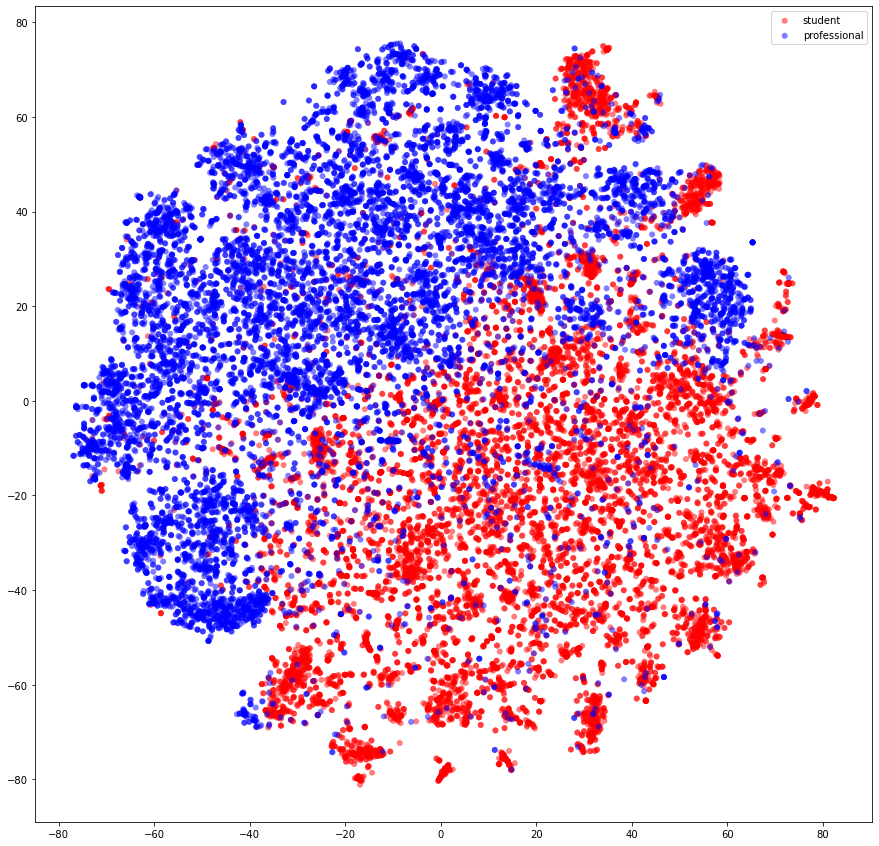

In [36]:
visu_embeddings(usr_tsne_emb, usr_tsne_lab)